In [3]:
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from traitlets import traitlets
from IPython.display import display
from ipywidgets import HBox, VBox, BoundedFloatText, BoundedIntText, Text, Layout, Button

# Processing demographic data

We have retrieved demographic data from the data portal of the **National Centre for Statistics & Information** of the *Sultanate of Oman* (https://data.gov.om/)

Data are formatted in a two-columns file, where<br>
*  The __first__ column contains _years_.<br>
*  The __second__ column, which must be named *Population*, contains integer numbers and reports the total population in the Muscat region per year [2010-2019]

In [7]:
if os.path.exists("./playgrounds/data/JNNP_2020/Epidemiology_Oman.txt"):
    epi_file = "./playgrounds/data/JNNP_2020/Epidemiology_Oman.txt"
elif not os.path.exists("./data/JNNP_2020/Epidemiology_Oman.txt"):
    !git clone https://github.com/mazzalab/playgrounds.git
    epi_file = "./playgrounds/data/JNNP_2020/Epidemiology_Oman.txt"
else:
    epi_file = "./data/JNNP_2020/Epidemiology_Oman.txt"
    
df = pd.read_csv(epi_file, sep='\t', index_col=0)
print(df)

      Population
Year            
2010      407006
2011      418652
2012      435149
2013      451652
2014      470085
2015      487592
2016      512039
2017      528327
2018      543930


## Predicting Muscat population growth

The observed period of time starts in **2014** and ends in the year specified below.

In [38]:
style = {'description_width': 'initial'}

simulation_end_text = BoundedIntText(
    min=2015,
    max=2100,
    step=1,
    value=2050,
    description='Simulate from 2014 until:', style=style)

class GenerateTimeButton(Button):
    def __init__(self, value=None, *args, **kwargs):
        super(GenerateTimeButton, self).__init__(*args, **kwargs)
        # Create the value attribute.
        self.add_traits(value=traitlets.Any(value))
        
# Generate time period (list of years) to be simulated
def on_generate_time_button_clicked(button):
    button.value = np.arange(2014, simulation_end_text.value+1, 1).reshape((-1, 1))
    print("Simulation time points generated")

generate_time_button = GenerateTimeButton(
    description="Generate",
    button_style='info',
    tooltip='Generate simulation time points'
)
generate_time_button.value=np.array([])
generate_time_button.on_click(on_generate_time_button_clicked)

hbox_time = HBox([simulation_end_text, generate_time_button])
display(hbox_time)

Linear regression analysis is conducted on demographic data using the *LinearRegression* module from the Python **sklearn** package. The typical linear regression equation: \begin{align}y & = mx + b\end{align} is fitted and *coefficient of determination ($r^2$)*, *intercept* ($b$) and *slope* ($m$) are inferred.

Simulation time points generated
 
coefficient of determination: 0.996
intercept (b): -35324154.9
slope (m): [17774.017]

time:				[2010 2011 2012 2013 2014 2015 2016 2017 2018]
predicted response:		[401619. 419393. 437167. 454941. 472715. 490489. 508263. 526037. 543811.]
predicted response [2018]	543811.0
actual data [Dec. 2018]:	543930
predicted response [2019]	561585.0
actual data [Dec. 2019]:	567851
predicted response [2020]	579359.0
actual data [Feb. 2020]:	570196


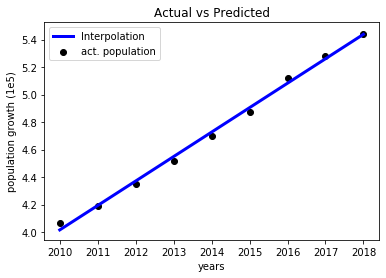

In [39]:
if not generate_time_button.value.any():
    simulation_end_text.value=2050
    generate_time_button.click()

x_new = generate_time_button.value

#######################################

%matplotlib inline
x = df.index.values.reshape((-1, 1))
y = df.Population
model = LinearRegression().fit(x, y)

r_sq = model.score(x, y)
print(" ")
print('coefficient of determination:', np.round(r_sq, 3))
print('intercept (b):', np.round(model.intercept_, 3))
print('slope (m):', np.round(model.coef_, 3))
print('')

# Predict response of known data
y_pred = model.predict(x)
print('time:', np.transpose(x)[0], sep='\t\t\t\t')
print('predicted response:', np.around(y_pred), sep='\t\t')

# Plot outputs
axis_scale = 1e5
plt.scatter(x, y/axis_scale,  color='black', label="act. population")
plt.plot(x, y_pred/axis_scale, color='blue',
         linewidth=3, label="Interpolation")

plt.title('Actual vs Predicted')
plt.xlabel('years')
plt.ylabel('population growth (1e5)')

plt.legend(loc='upper left')

# Predict response of future data [2018-2020]
y_pred = np.round(model.predict(x_new))
print('predicted response [2018]', y_pred[4], sep='\t')
print('actual data [Dec. 2018]:\t{}'.format(df.iloc[8]['Population']))

print('predicted response [2019]', y_pred[5], sep='\t')
print('actual data [Dec. 2019]:\t{}'.format(567851))

print('predicted response [2020]', y_pred[6], sep='\t')
print('actual data [Feb. 2020]:\t{}'.format(570196))

# Markov Chain design

A **discrete-time Markov chain (DTMC)** is designed to model the *death* event of HD patients and *onset* of the disease among inhabitants of Muscat. To do that, *birth/death* events were inferred from observational data collected from 2013 to 2019 in the Muscat population.

## Set the transition rates

The modeled process is stochastic and *memoryless*, in that it allows to make predictions based solely on its present state. The process passes through three states: **Healthy**, **HD Alive** and **HD Dead** as a result of *birth* and *death* events, driven in turn by: <b>I</b> = incidence rate of the disease and <b>D</b> = death rate because of the disease.<br/>
<img src="data/JNNP_2020/MC_states.png" align="middle" width="300">

where:<br/>
* $I_{avg}$: &emsp;the average HD incidence rate in the world population (**0.38** per 100,000 per year) [https://doi.org/10.1002/mds.25075]
* $I_{Muscat}$: the actual HD incidence rate in Muscat (**0.56** per 100,000 per year [2013-2019])
* $D_{avg}$: &emsp;the HD death rate registered in England-Wales in 1960-1973 (**1.55** per million population) [https://pubmed.ncbi.nlm.nih.gov/6233902/]
* $D_{Muscat}$: the actual HD death rate in Muscat (**1.82** per million population [2013-2019])

In [40]:
# estimated incidence rate world-wide (0.38 per 100,000 per year) [https://doi.org/10.1002/mds.25075]
est_inc_rate_text = BoundedFloatText(
    min=0.25,
    max=0.45,
    step=0.05,
    value=0.38,
    description='$I_{avg}$ (per 100.000):', style=style)

# actual incidence rate (0.56 per 100,000 per year) ~ 3 new HD patients in Muscat in 2018 [https://data.gov.om/OMPOP2016/population?indicator=1000140&region=1000020-muscat&nationality=1000010-omani]
act_inc_rate_text = BoundedFloatText(
    min=0.45,
    max=0.65,
    step=0.05,
    value=0.56,
    description='$I_{Muscat}$ (per 100.000):', style=style)

# estimated death rate as for England-Wales in 1960-1973 were 1.55 per million population
# http://europepmc.org/backend/ptpmcrender.fcgi?accid=PMC1684448&blobtype=pdf
est_death_rate_text = BoundedFloatText(
    description='$D_{avg}$ (per 100.000):', 
    style=style,
    min=0.12,
    max=0.18,
    step=0.005,
    value=0.155
)

# actual death rate ~ 1 patient in 2018 per 100.000 per year in Muscat
act_death_rate_text = BoundedFloatText(
    min=0.16,
    max=0.2,
    step=0.01,
    value=0.1819,
    description='$D_{Muscat}$ (per 100.000):', style=style)

# starting HD population in Muscat in 2014 (32)
hd_2014_text = BoundedIntText(
    min=0,
    max=1000,
    step=1,
    value=32,
    description='HD prevalence in Muscat in 2014:', style=style,
    layout=Layout(height='50px'))

left_box = VBox([est_inc_rate_text, act_inc_rate_text, hd_2014_text])
right_box = VBox([est_death_rate_text, act_death_rate_text])
hbox = HBox([left_box, right_box])

display(hbox)

### Set the number of simulation traces

In order to approximate the posterior distribution of the HD prevalence, one performs a *Monte Carlo* simulation with $1000$ independent simulation runs from where calculating the *average number of incident cases* per year.

In [29]:
simulation_traces = BoundedIntText(
    min=1,
    max=5000,
    step=1,
    value=1000,
    description='Simulation traces:', style=style)
display(simulation_traces)

BoundedIntText(value=1000, description='Simulation traces:', max=5000, min=1, style=DescriptionStyle(descripti…

### Initialize state vectors

For each simulation step, $6$ vectors are updated:<br/>
* ***est_inc*** stores the variation of incidence over time according to $I_{avg}$
* ***act_inc*** stores the variation of incidence over time according to $I_{Muscat}$
* ***est_death*** stores the numbers of deaths over time according to $D_{avg}$
* ***act_death*** stores the numbers of deaths over time according to $D_{Muscat}$
* ***est_alive_HD*** stores the number of alive HD patients over time, based on ***est_inc*** and ***est_death***
* ***act_alive_HD*** astores the number of alive HD patients over time, based on ***act_inc*** and ***act_death***

In [30]:
# record the number of simulation steps
sim_time = len(x_new)

# get the number of simulation traces from the textfield above
num_traces = simulation_traces.value

est_inc = np.zeros((num_traces, sim_time), dtype=int)
act_inc = np.zeros((num_traces, sim_time), dtype=int)

est_death = np.zeros((num_traces, sim_time), dtype=int)
act_death = np.zeros((num_traces, sim_time), dtype=int)

est_alive_HD = np.zeros((num_traces, sim_time), dtype=int)
est_alive_HD[:, 0] = hd_2014_text.value
act_alive_HD = np.zeros((num_traces, sim_time), dtype=int)
act_alive_HD[:, 0] = hd_2014_text.value

### Trigger the Monte Carlo simulation

For each independent simulation and for each time step, the number of alive HD patients is calculated as the sum of the number of *currently alive* HD patients and that of *new* HD patients, from which the number of currently *deceased* patients is subtracted.

In [31]:
for rep in range(num_traces):
    for t in range(sim_time-1):
        curr_pop = y_pred[t]

        est_inc[rep, t] = np.random.poisson(
            (est_inc_rate_text.value * curr_pop)/100000)
        act_inc[rep, t] = np.random.poisson(
            (act_inc_rate_text.value * curr_pop)/100000)

        est_death[rep, t] = np.random.poisson(
            (est_death_rate_text.value * curr_pop)/100000)
        act_death[rep, t] = np.random.poisson(
            (act_death_rate_text.value * curr_pop)/100000)

        est_alive_HD[rep, t+1] = est_alive_HD[rep, t] - \
            est_death[rep, t] + est_inc[rep, t]
        act_alive_HD[rep, t+1] = act_alive_HD[rep, t] - \
            act_death[rep, t] + act_inc[rep, t]

### Plot HD population predicted to be alive

N.b., __est. HD population__ accounts for the population that is predicted to be alive every year according to *incidence* and *death* rates that are the world average; __act. HD population__ refers instead to the actual rates calculated stright on the actual Muscat population records, as previously described.

Button(button_style='info', description='Save SVG', style=ButtonStyle(), tooltip='Save to SVG file')

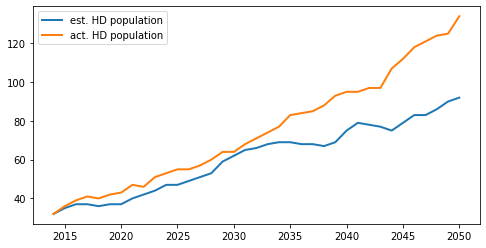

In [41]:
# Select a random trace
rtrace = np.random.randint(0,num_traces)

# Plot a random trace of est/act. alive HD cases in the Muscat region
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(x_new, est_alive_HD[rtrace, :], lw=2, label='est. HD population')
ax.plot(x_new, act_alive_HD[rtrace, :], lw=2, label='act. HD population')
ax.legend(loc='upper left')

def on_save_alive_pop_button(but):
    fig.savefig('alive_population.svg', format='svg', dpi=1200)
    print('Figure saved')

save_alive_button = Button(
    description="Save SVG",
    button_style='info',
    tooltip='Save to SVG file'
)
save_alive_button.on_click(on_save_alive_pop_button)
display(save_alive_button)

# Calculate average estimates of prevalence over traces

The **prevalence** of HD is calculated year by year until the end of simulation and for each simulation trace.

In [33]:
# Calculate prevalence for each year and for each simulation trace
prev_HD = np.round((act_alive_HD / y_pred)*1e5, 2)
print(prev_HD)

[[ 6.77  6.93  7.08 ... 11.14 11.51 11.68]
 [ 6.77  6.32  6.3  ... 11.51 11.6  11.59]
 [ 6.77  6.73  7.48 ... 12.91 13.15 13.39]
 ...
 [ 6.77  6.52  7.08 ... 13.09 13.15 13.93]
 [ 6.77  6.93  6.69 ... 12.81 12.6  12.94]
 [ 6.77  6.93  7.08 ... 11.88 12.06 12.76]]


### Plot prevalence estimates

Calculate the **average prevalence** values ($\mu$) for each year and over all simulation traces, together with the **standard deviation** ($\sigma$) values.<br/>
Make a line plot with bands, with *years* on the X-axis and the *prevalence* values on the Y-axis.

Button(button_style='info', description='Save SVG', style=ButtonStyle(), tooltip='Save to SVG file')

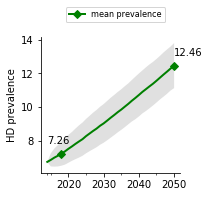

In [34]:
# calculate average and standard deviation of prevalence data over all traces
mu = prev_HD.mean(axis=0)
sigma = prev_HD.std(axis=0)

# Get the prevalence estimate for 2019, as a crosscheck with real data
prev_2019 = mu[4]
prev_2050 = mu[len(mu)-1]

# instantiate and configure the final plot
fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5))
markers_on = [4, len(mu)-1]
ax.plot(x_new, prev_HD.mean(axis=0), '-gD', lw=2, label='mean prevalence', markevery=markers_on)
ax.set_ylabel('HD prevalence')
ax.legend(loc='upper left', bbox_to_anchor=(0.15, 1.25), ncol=1, prop={"size":8})
ax.set_xticks([2014, 2015, 2025, 2035, 2045], minor=True)
ax.fill_between(x_new.flatten(), mu+sigma, mu-sigma, facecolor='lightgray', alpha=0.7)

plt.annotate(np.round(prev_2019,2),
                 (2014,prev_2019),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='left')
plt.annotate(np.round(prev_2050,2),
                 (2050,prev_2050),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='left')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)


def on_save_prevalence_button(but):
    fig.savefig('act_prevalence.svg', format='svg', dpi=1200)
    print('Figure saved')

save_prevalence_button = Button(
    description="Save SVG",
    button_style='info',
    tooltip='Save to SVG file'
)
save_prevalence_button.on_click(on_save_prevalence_button)
display(save_prevalence_button)

### Generate a prevalence table

In [35]:
prev_df = pd.DataFrame({'Years':x_new.flatten(), 'Prevalence':mu})
print(prev_df.head())

def on_save_prevalence_table_button(but):
    prev_df.to_excel("prevalence_table.xlsx", index=False)  
    print('Figure saved')

save_prevalence_table_button = Button(
    description="Save XLSX",
    button_style='info',
    tooltip='Save to Excel file'
)
save_prevalence_table_button.on_click(on_save_prevalence_table_button)
display(save_prevalence_table_button)

   Years  Prevalence
0   2014     6.77000
1   2015     6.88803
2   2016     7.02210
3   2017     7.13165
4   2018     7.25717


Button(button_style='info', description='Save XLSX', style=ButtonStyle(), tooltip='Save to Excel file')

### Miscellaneous plots

Create two plots of **frequency** of *adults*, *youngs* HD and *at-risk* subjects.

  Patients  Adult-onset  Juvenile-onset
0    Alive           41               4
1     Dead           26               5
2     >50%           10               0
3    Total           67               9

  Patients  ≤50% risk  >50% risk
0    Alive        240         64
1     Dead         19          2



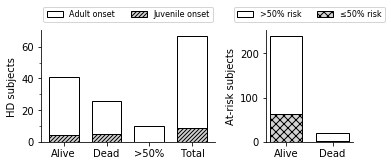

Button(button_style='info', description='Save SVG', style=ButtonStyle(), tooltip='Save to SVG file')

In [42]:
bars_file = "./data/JNNP_2020/Bar_plots.xlsx"
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5.5, 2.5), gridspec_kw={'width_ratios': [2, 1]})


######## Panel A ########
dfA = pd.read_excel(bars_file, sheet_name="Figure A") #index_col=0, 
print(dfA)
print("")

labels = dfA.Patients
x = np.arange(len(labels))

adult_onset = dfA.iloc[:,1]
juvenile_onset = dfA.iloc[:,2]

width = 0.35*2  # the width of the bars
rects1 = ax1.bar(x, adult_onset, width, label='Adult onset', 
                 color='white', edgecolor='black')
rects2 = ax1.bar(x, juvenile_onset, width, label='Juvenile onset', 
                 color='lightgray', edgecolor='black', hatch="//////")

ax1.set_ylabel('HD subjects')
ax1.set_xticks(x)
ax1.set_yticks([10, 30, 50], minor=True)
ax1.set_xticklabels(labels)
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25),ncol=2, prop={"size":8})

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)

######## Panel B ########
dfB = pd.read_excel(bars_file, sheet_name="Figure B")
print(dfB)
print("")

labels = dfB.Patients
more50 = dfB.iloc[:,1]
less50 = dfB.iloc[:,2]

x = np.arange(len(labels))
width = 0.35*2

rects1 = ax2.bar(x, more50, width, label='>50% risk', 
                 color='white', edgecolor='black')
rects2 = ax2.bar(x, less50, width, label='≤50% risk', 
                 color='lightgray', edgecolor='black', hatch="xXX")

ax2.set_ylabel('At-risk subjects')
ax2.set_xticks(x)
ax2.set_xticklabels(labels)
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25),ncol=2, prop={"size":8})

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2.spines['left'].set_visible(True)


##### Plotting #####
fig.tight_layout()

plt.rcParams.update({'font.size': 10})
plt.show()


def on_save_misc_button(but):
    fig.savefig('misc_plots.svg', format='svg', dpi=1200)
    print('Figure saved')

save_misc_button = Button(
    description="Save SVG",
    button_style='info',
    tooltip='Save to SVG file'
)
save_misc_button.on_click(on_save_misc_button)
display(save_misc_button)

# Print system and required packages information

In [37]:
%load_ext watermark
%watermark -v -m -p numpy,pandas,matplotlib,sklearn,traitlets,IPython,ipywidgets

# date
print(" ")
%watermark -u -n -t -z

CPython 3.7.6
IPython 7.12.0

numpy 1.18.1
pandas 1.0.1
matplotlib 3.1.3
sklearn 0.22.1
traitlets 4.3.3
IPython 7.12.0
ipywidgets 7.5.1

compiler   : MSC v.1916 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 60 Stepping 3, GenuineIntel
CPU cores  : 8
interpreter: 64bit
 
last updated: Thu Mar 12 2020 16:04:44 W. Europe Standard Time
